<a href="https://colab.research.google.com/gist/ctrivino1/f4c25bd4c26368555664b797ab90662d/stats_gtg_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the images from git:

In [1]:
!git clone https://github.com/JigglyNoahPuff/Good2Go_Lanes.git

Cloning into 'Good2Go_Lanes'...
remote: Enumerating objects: 6956, done.
remote: Counting objects: 100% (398/398), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 6956 (delta 289), reused 321 (delta 218), pack-reused 6558
Receiving objects: 100% (6956/6956), 473.71 MiB | 35.91 MiB/s, done.
Resolving deltas: 100% (4005/4005), done.
Checking out files: 100% (9188/9188), done.


Import the libraries:

In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import ResNet50
tf.config.run_functions_eagerly(False)

Read in the data:

In [3]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

training_dir = '/content/Good2Go_Lanes/Good2Go_final_Balance'
image_size = (400, 600)

# Split up the training data images into training and validations sets
training_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='training', seed=42, image_size=image_size)
validation_data = image_dataset_from_directory(training_dir, validation_split=.2, subset='validation', seed=42, image_size=image_size)

# Get some nice stats
import re
paths = training_data.file_paths
file_classes = [re.search(r'[0-9]_lane',item).group() for item in paths]
counts = [(x,file_classes.count(x)) for x in set(file_classes)]
total_files = len(file_classes)
class_pc = sorted([(x[0],x[1]/total_files) for x in counts], key=lambda tup: tup[1], reverse=True)
nir = class_pc[0][1]
print(f"Largest class ({class_pc[0][0]}) is {round(class_pc[0][1]*100,2)}% of the data, so the " +
      "accuracy needs to be greater than that to be better than just guessing.") 

Found 3615 files belonging to 5 classes.
Using 2892 files for training.
Found 3615 files belonging to 5 classes.
Using 723 files for validation.
Largest class (3_lane) is 21.44% of the data, so the accuracy needs to be greater than that to be better than just guessing.


Augment the data:

In [4]:
from tensorflow.keras import layers
# IMG_SIZE = 256

resize_and_rescale = tf.keras.Sequential([
  layers.Dense(1,input_shape=(400,600,3)),
  # layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./256)
])



aug_ds = training_data.map(
    lambda x, y: (resize_and_rescale(x, training=True),y)
)


data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal",seed=0),
  # layers.experimental.preprocessing.RandomRotation(0.1,seed=1),
])

augmented_training_data = training_data.map(
    lambda x, y: (data_augmentation(x, training=True),y)
)

Show the augmented data:

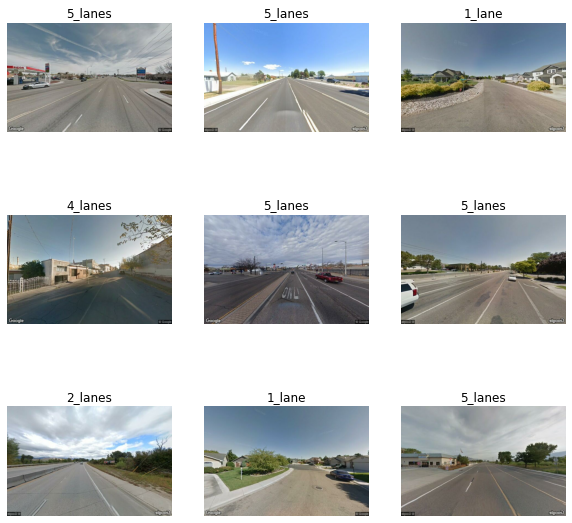

In [5]:
# shows the augmented training images
import matplotlib.pyplot as plt

# View first 9 images and their class labels
plt.figure(figsize=(10, 10))
for images, labels in augmented_training_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(training_data.class_names[labels[i]])
    plt.axis("off")



## ResNet50 Model

Train the ResNet50 model:

In [ ]:
num_epochs = 50
import datetime
%load_ext tensorboard
from tensorflow.python.keras.callbacks import TensorBoard
!pip install keras-rectified-adam
from keras_radam import RAdam

#from keras_radam.training import RAdamOptimizer

## imports ResNet50 model 

base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(400,600,3), pooling="max"
)
#.50 @ 196 epoch's


# efficient B7 model

# Freeze the base model
base_model.trainable = False

# Adds ResNet50 into a model with a output layers with 3 classifaction nodes
model = keras.Sequential([
    base_model,tf.keras.layers.Dropout(.6),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(5) # number of perceptrons
])

import tensorflow_probability as tfp

# Mean absolute error (float based)
# "What is the distance on average between the predicted and actual label?"
def mean_err(y_true, y_pred):
  true_vec = tf.reshape(y_true, [-1])
  pred_vec = tf.argmax(input=y_pred,axis=1)
  mae = tf.keras.losses.MeanAbsoluteError()
  # Calculate the mean absolute error 
  # (the average of the absolute value of the predicted number of lanes minus the actual)
  v = mae(tf.cast(true_vec,dtype=tf.float32), tf.cast(pred_vec,dtype=tf.float32))
  #devs = tf.math.abs(tf.cast(true_vec,dtype=tf.float32)-tf.cast(pred_vec,dtype=tf.float32))
  #v = tf.math.reduce_mean(devs)
  return v

# First quartile of MAE
def err_1q(y_true, y_pred):
  true_vec = tf.reshape(y_true, [-1])
  pred_vec = tf.argmax(input=y_pred,axis=1)
  devs = tf.math.abs(tf.cast(true_vec,dtype=tf.float32)-tf.cast(pred_vec,dtype=tf.float32))
  return tfp.stats.percentile(devs, interpolation='linear', q=25)

# Third quartile of MAE
def err_3q(y_true, y_pred):
  true_vec = tf.reshape(y_true, [-1])
  pred_vec = tf.argmax(input=y_pred,axis=1)
  devs = tf.math.abs(tf.cast(true_vec,dtype=tf.float32)-tf.cast(pred_vec,dtype=tf.float32))
  return tfp.stats.percentile(devs, interpolation='linear', q=75)

#Skewness
def skew(y_true, y_pred):
  true_vec = tf.reshape(y_true, [-1])
  pred_vec = tf.argmax(input=y_pred,axis=1)
  devs = tf.math.abs(tf.cast(true_vec,dtype=tf.float32)-tf.cast(pred_vec,dtype=tf.float32))
  med = tfp.stats.percentile(devs, interpolation='linear', q=50)
  mean = tf.math.reduce_mean(devs)
  sd = tfp.stats.stddev(devs)
  return 3*(mean - med)/sd

def get_rank(tens):
  pass

# Calculate discounted cumulative gain, not done
def dcg(y_true, y_pred):
  true_vec = tf.reshape(y_true, [-1])
  for i in range(len(true_vec)):
    pass
    #tf.print(true_vec[i])
  return 0

# Mean rank
def mr(y_true, y_pred):
  true_vec = tf.cast(tf.reshape(y_true, [-1]),dtype=tf.float32)
  vlen = len(true_vec)
  #recip_ranks = tf.Variable(tf.zeros(vlen))
  recip_ranks = tf.zeros(vlen)
  #tf.print("\n")
  #tf.print(recip_ranks)
  shape = vlen
  for i in range(vlen):
    #tf.print(i)
    i = int(i)
    true_label = tf.cast(true_vec[i],dtype=tf.int32)
    pred_vec = y_pred[i]
    order = tf.argsort(pred_vec)
    ranks = tf.subtract(len(pred_vec),order)
    rank = ranks[true_label]
    recip_ranks = tf.tensor_scatter_nd_update(recip_ranks,[[i]],tf.cast([rank],dtype=tf.float32))
  #tf.print(recip_ranks)
  return tf.math.reduce_mean(recip_ranks)
  return 0

# Almost accurate
def almost_acc(y_true, y_pred):
  true_vec = tf.cast(tf.reshape(y_true, [-1]),dtype=tf.float32)
  pred_vec = tf.cast(tf.argmax(input=y_pred,axis=1),dtype=tf.float32)
  vlen = len(true_vec)
  output_vector = tf.zeros(vlen)
  for i in range(vlen):
    true_label = true_vec[i]
    pred_label = pred_vec[i]
    if(tf.math.abs(true_label - pred_label) <= 1):
       output_vector = tf.tensor_scatter_nd_update(output_vector,[[i]],[1.0])
  return tf.math.reduce_mean(output_vector)

# This is just the same as the accuracy, to test if I am programming this correctly
def acc2(y_true, y_pred):
  true_vec = tf.cast(tf.reshape(y_true, [-1]),dtype=tf.float32)
  pred_vec = tf.cast(tf.argmax(input=y_pred,axis=1),dtype=tf.float32)
  vlen = len(true_vec)
  output_vector = tf.zeros(vlen)
  for i in range(vlen):
    true_label = true_vec[i]
    pred_label = pred_vec[i]
    #tf.print(tf.math.abs(true_label - pred_label))
    if(tf.math.abs(true_label - pred_label) == 0):
       output_vector = tf.tensor_scatter_nd_update(output_vector,[[i]],[1.0])
  #tf.print(output_vector)
  return tf.math.reduce_mean(output_vector)

# Compile & train
# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=RAdam(learning_rate=1e-3), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy',almost_acc,acc2])


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/tmp/checkpoint',
    monitor='val_almost_acc',
    mode='max',
    save_best_only=True)

history = model.fit(augmented_training_data, validation_data = validation_data, epochs=num_epochs, callbacks=[model_checkpoint_callback,tensorboard_callback])

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.19.0-cp37-none-any.whl size=9018 sha256=3d4597100f4287934de14fb2c0aa48d60391b8a6d5d9fcda94c0a80707f0d5c9
  Stored in directory: /root/.cache/pip/wheels/02/1e/17/465c89b2c5ce7670a3fc6c20c40e1dad994109d015d57a024e
Successfully built keras-rectified-adam
94773248/94765736 [==============================] - 3s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
91/91 [==============================] - 114s 853ms/step - loss: 5.6589 - accuracy: 0.2355 - almost_acc: 0.5635 - acc2: 0.2356 - val_loss: 1.7849 - val_accuracy: 0.3264 - val_almost_acc: 0.5994 - val_acc2: 0.3244


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/50
91/91 [==============================] - 77s 836ms/step - loss: 2.7541 - accuracy: 0.2801 - almost_acc: 0.6059 - acc2: 0.2799 - val_loss: 1.5678 - val_accuracy: 0.2877 - val_almost_acc: 0.6814 - val_acc2: 0.2835


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/50
91/91 [==============================] - 74s 800ms/step - loss: 2.0349 - accuracy: 0.3140 - almost_acc: 0.6603 - acc2: 0.3147 - val_loss: 1.5106 - val_accuracy: 0.3140 - val_almost_acc: 0.7263 - val_acc2: 0.3159


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/50
91/91 [==============================] - 74s 803ms/step - loss: 1.6903 - accuracy: 0.3468 - almost_acc: 0.6893 - acc2: 0.3462 - val_loss: 1.4293 - val_accuracy: 0.3098 - val_almost_acc: 0.6443 - val_acc2: 0.3081
Epoch 5/50
91/91 [==============================] - 75s 811ms/step - loss: 1.5814 - accuracy: 0.3600 - almost_acc: 0.7121 - acc2: 0.3615 - val_loss: 1.4307 - val_accuracy: 0.3748 - val_almost_acc: 0.6787 - val_acc2: 0.3756
Epoch 6/50
91/91 [==============================] - 75s 817ms/step - loss: 1.5010 - accuracy: 0.3721 - almost_acc: 0.7333 - acc2: 0.3724 - val_loss: 1.2186 - val_accuracy: 0.4661 - val_almost_acc: 0.7948 - val_acc2: 0.4625


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 7/50
80/91 [=========================>....] - ETA: 7s - loss: 1.3919 - accuracy: 0.4051 - almost_acc: 0.7473 - acc2: 0.4051

Graph the model accuracy:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
acc = history.history['almost_acc']
val_acc = history.history['val_almost_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Almost Accuracy')
plt.plot(epochs_range, val_acc, label='Validation almost Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
# model.load_weights(checkpoint_filepath)

Show an interactive plot of model accuracy:

In [ ]:
%tensorboard --logdir logs/fit # this tensorboard portrays the visualzations above, but looks better and is interactive.

In [ ]:
!unzip '/content/TestSet-20210712T203618Z-001.zip'


In [ ]:
import pathlib

def predict_an_image(model, file_path):
  # Load the image
  img = keras.preprocessing.image.load_img(file_path, target_size=(400, 600))
  
  # Get the image into the shape we need for our network
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) 
  # Predict the class
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  return np.argmax(score) + 1


def get_row_prediction(row):
  return predict_an_image(model, f"/content/TestSet/{row['Lanes']}/{row['Image_Name']}")


realLanes = pd.read_csv('testAddresses.csv')

realLanes['Prediction'] = realLanes.apply(get_row_prediction, axis=1)
realLanes.to_csv('testAddressWithPredictions.csv', index=False, )
realLanes.head(50)

In [ ]:
model.save_weights('model_weights/weightsFinal')
realLanes.to_csv('testAddressesWithPredictions.csv')

In [ ]:
!pip install keras-rectified-adam
from keras_radam import RAdam


base_model = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(400,600,3), pooling="max"
)

base_model.trainable = False

new_model = keras.Sequential([
    base_model,
    tf.keras.layers.Dropout(.6),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(5) # number of perceptrons
])

# Check its architecture
new_model.load_weights('model_weights/weightsFinal')

In [ ]:
img = keras.preprocessing.image.load_img('TestSet/1/img_01_008.jpg', target_size=(400, 600))
  
# Get the image into the shape we need for our network
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
# Predict the class
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
np.argmax(score) + 1

In [ ]:
!pip install keras-rectified-adam
from keras_radam import RAdam